In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
from functions import *

random.seed(26)
np.random.seed(26)

In [2]:
ds = pd.read_csv("poly_regression_large.csv")
# Inspect the data
print(f"Shape of the data: {ds.shape}")
print("")
# Convert data into a matrix
data = np.array(ds)

# Extract the test part
X = data[:, 1]
Y = data[:, 2]
_, (X_test, Y_test) = split_data(X, Y, per_train=0.8)

train_csv = pd.read_csv("poly_regression_small.csv")
train = np.array(train_csv)
X_train, Y_train = train[:, 1], train[:, 2]

Shape of the data: (1000, 3)

Train test split = 800, 200


In [33]:
def loss_MAP(theta,params_f): 
    X, Y, lam = params_f
    Phi_X = polynomial_features(X, len(theta))
    return (np.linalg.norm(Phi_X @ theta - Y)**2 + lam * np.linalg.norm(theta) ** 2)/2 

def grad_loss_MAP(theta,params_f): 
    X, Y, lam = params_f
    Phi_X = polynomial_features(X, len(theta))
    return Phi_X.T @ (Phi_X @ theta - Y) + lam * theta

def loss_MLE(theta,params_f): 
    X, Y = params_f
    Phi_X = polynomial_features(X, len(theta)).T 
    
    return (np.linalg.norm(Phi_X @ theta - Y)**2)/2

def grad_loss_MLE(theta,params_f): 
    X, Y = params_f
    Phi_X = polynomial_features(X, len(theta)).T
    return Phi_X.T @ (Phi_X @ theta - Y)

def MLE(D,degree_poly):
    X,Y = D
    K = degree_poly
    Phi_X = polynomial_features(X, K).T
    return np.linalg.inv(Phi_X.T @ Phi_X) @ Phi_X.T @ Y

def MAP(D, degree_poly, l):
    X,Y = D
    K = degree_poly
    Phi_X = polynomial_features(X, K)
    return np.linalg.inv(Phi_X.T @ Phi_X + l*np.identity(K)) @ Phi_X.T @ Y

def compute_weights(data, method, loss = None, grad_loss = None, batch_size=50, n_epochs=500,kmax=1000, alpha=0.1, lam=None, kk=range(10), approach='MLE'):
    X,Y = data
    thetas = []
    converging_kk = []
    for k in kk:# (tqdm(kk,desc='Optimize'))
        theta_0 = np.ones((k,))
        degree_poly = k
            
        if method == "GD":
            if lam is None:
                params_f = (X,Y)
            else:
                params_f = (X,Y,lam)
            x,maxit,f_val,grads,err,converge, message = GD(loss, grad_loss,params_f, x0=theta_0, maxit=kmax)
            # if converge:
            print(message)
            thetas.append(x[-1])
            converging_kk.append(k)
            # else:
                # print(f"Convergence not reached for k={k}: {message}")
        elif method == "SGD":
            if lam is None:
                params_f = (X,Y)
            else:
                params_f = (X,Y,lam)
            theta_history, loss_history, grad_norm_history = SGD_poly(loss, grad_loss, params_f= params_f,degree_poly = degree_poly, theta0=theta_0, alpha=alpha, batch_size=batch_size, n_epochs=n_epochs)
            thetas.append(theta_history[-1])
            converging_kk.append(k)
        elif method == "Normal":
            if approach == 'MLE':
                theta_MLE = MLE(data,k)
                thetas.append(theta_MLE)
                converging_kk.append(k)
            elif approach == 'MAP':
                theta_MAP = MAP(data,k, l=lam)
                thetas.append(theta_MAP)
                converging_kk.append(k)
            else:
                raise ValueError(f'Unknown approach')
        else:
            raise ValueError(f'Unknown value for method') 

    return thetas, converging_kk

In [34]:
train_data = (X_train, Y_train)
kk = range(1,11,3)
alpha = 0.01

Reached maxit
Diverging 2
Diverging 2
Diverging 2
1
[74320503.54507867 74320503.54507867 74320503.54507867 74320503.54507867
 74320503.54507867]
4
[1.35369732e+08 1.79729360e+08 1.41738860e+08 2.17869498e+08
 2.25779935e+08]
7
[6.42904454e+08 8.75346529e+08 6.74689104e+08 1.12201798e+09
 1.18145449e+09]
10
[1.53201464e+09 2.10655852e+09 1.60990415e+09 2.75194902e+09
 2.91831128e+09]


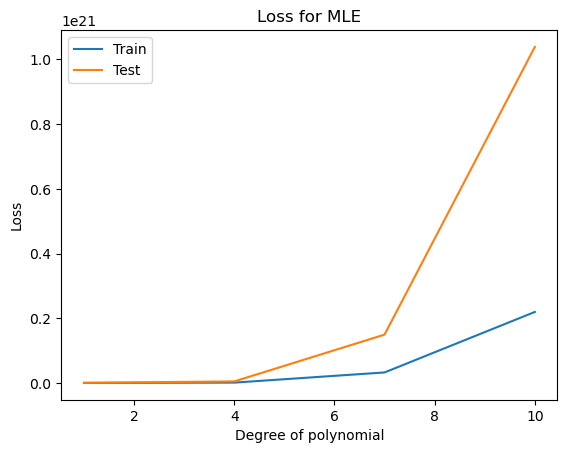

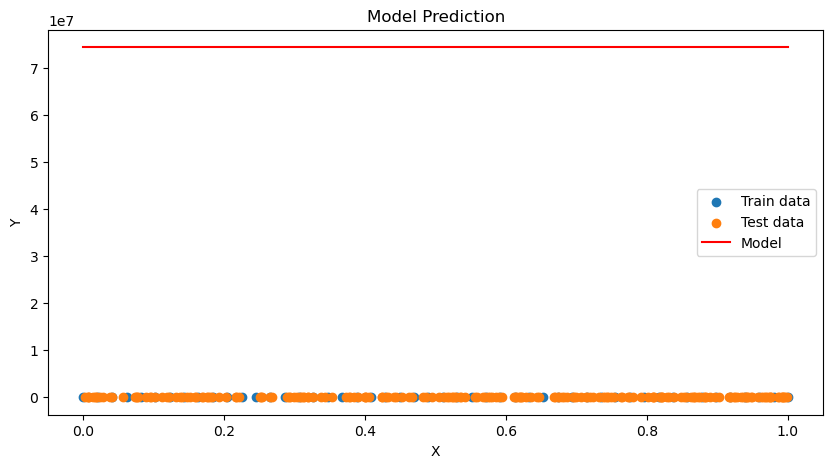

In [35]:
thetas, converging_kk = compute_weights(train_data, 'GD', loss=loss_MLE
, grad_loss=grad_loss_MLE, kk=kk, approach='MAP', kmax=15, alpha=0.001)
for theta in thetas:
    print(len(theta))
    print(predict_poly(X_test, theta)[0:5])

plt.figure()    
plt.plot(converging_kk, [loss_MLE(theta, (X_train, Y_train)) for theta in thetas], label='Train')
plt.plot(converging_kk, [loss_MLE(theta, (X_test, Y_test)) for theta in thetas], label='Test')
plt.xlabel('Degree of polynomial')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss for MLE')
plt.show()

plot_poly_regression(X_train, Y_train, X_test, Y_test, thetas[0])


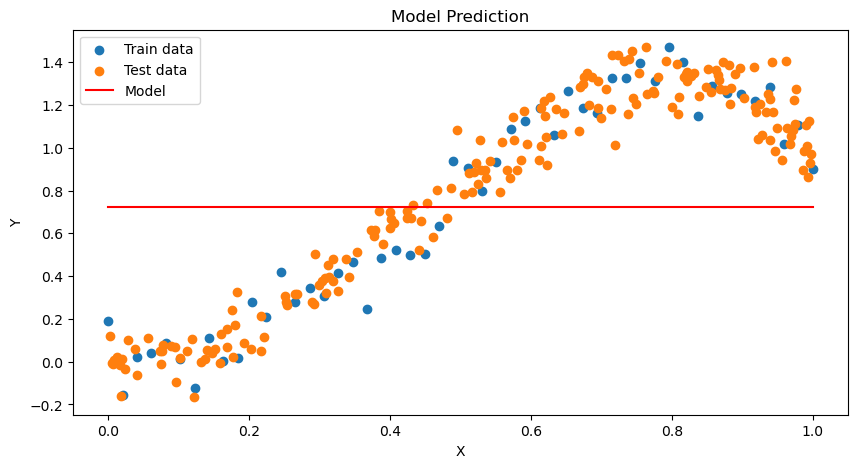

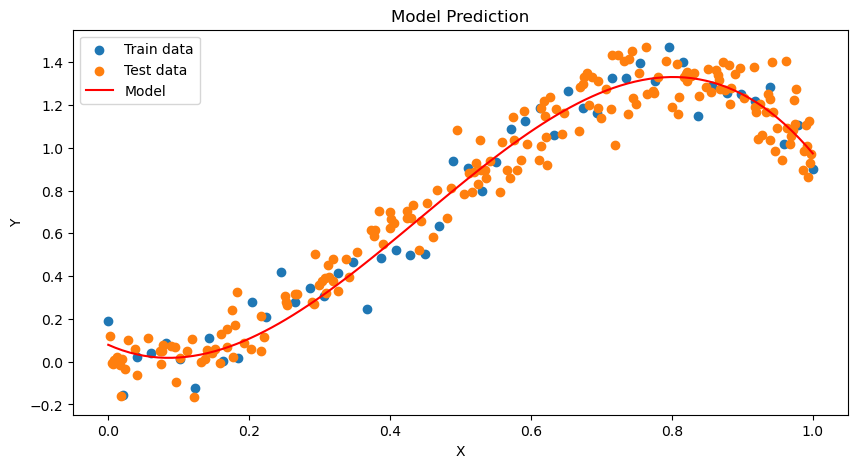

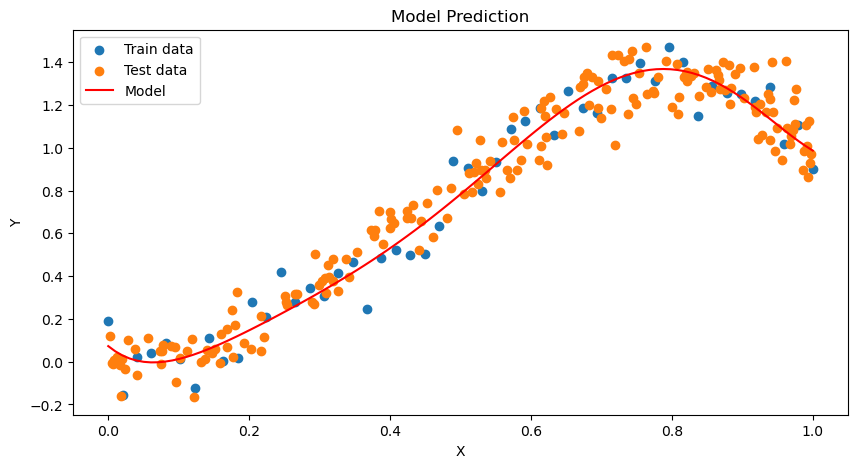

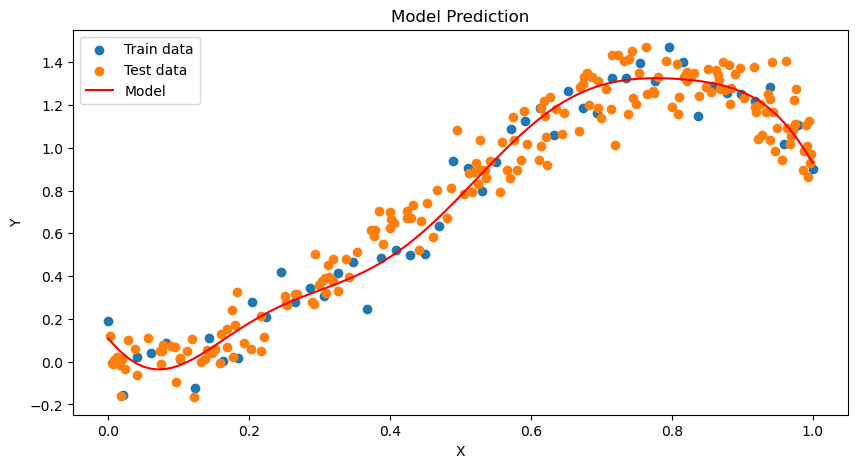

In [36]:
thetas, converging_kk = compute_weights(train_data, 'Normal', loss=loss_MLE, grad_loss=grad_loss_MLE, kk=kk, approach='MLE', n_epochs=10000, batch_size=5, alpha=alpha)
for theta in thetas:
    plot_poly_regression(X_train, Y_train, X_test, Y_test, theta)

In [37]:
# funzionano tutte e due
thetas, converging_kk = compute_weights(train_data, 'SGD', loss=loss_MAP, grad_loss=grad_loss_MAP, kk=kk, approach='MAP', n_epochs=10000, batch_size=5, alpha=alpha, lam=0.1)
# thetas, converging_kk = compute_weights(train_data, 'SGD', loss=loss_MLE, grad_loss=grad_loss_MLE, kk=kk, approach='MLE', n_epochs=10000, batch_size=5, alpha=alpha)
for theta in thetas:
    plot_poly_regression(X_train, Y_train, X_test, Y_test, theta)

ValueError: too many values to unpack (expected 2)